# Descripció del cristall de BN

```{note}
En este notebook va la major part del codi. De fet és on estan tots els càlculs.
```

In [1]:
# Netejem totes les variables 
#reset()

# Eixida per defecte en LaTeX
%display latex

# Importe les biblioteques i mètodes que empre al llarg del script
from pylab import loadtxt
import pandas as pd

#from myst_nb import glue

# Algunes funcions emprades
def matriu_simplificada(matriu,m,n):
    matsimp=matriu
    for i in range(m):
        for j in range(n):
             matsimp[i,j]=matriu[i,j].full_simplify()
    
    return matsimp

Donat que el càlcul dels modes de vibració per primers principis comença per establir la geomeria del cristall en equilibri, comprobem amb les dades proporcionades que el $BN$ monocapa es tracta d'un cristall bidimensional hexagonal de base diatómica, la cel·la unitat del qual ve donada per (dades proporcionades):

$$
\vec a_1=a(1,0);\qquad\vec a_2=a\left(-\frac{1}{2},\frac{\sqrt{3}}{2}\right);
$$

In [2]:
var('a', domain='positive')
a_1=a*vector([1,0])
a_2=a*vector([-1/2,sqrt(3)/2])

Comprobem que efectivament els dos vectors base formen un angle de

In [3]:
angle=arccos(a_1*a_2/(norm(a_1)*norm(a_2)))
#glue("angle_cela", angle, display=False)
show(angle, " radians")
#In-line text; {glue:}`angle`

2/3*pi ' radians'

Numerem les cel·les unitat amb un índex vectorial $\vec l=\left( l_1, l_2\right)$.


Les posicions dels nucs són $\vec R_{\vec l}=l_1\vec{a}_1+l_2\vec{a}_2$.
Visualitzem una regió de la xarxa hexagonal, amb els corresponents nucs (que no àtoms), així com la corresponent cel.la unitat,

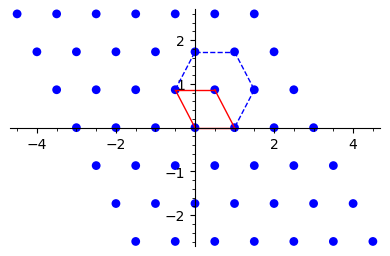

In [4]:
nucs=points([l_1*a_1/a+l_2*a_2/a for l_1 in range(-3, 4) for l_2 in range(-3,4)], 
             size=40, color="blue", frame=False)

show(nucs+
    line([(0,0),(a_1/a)],color="red")+
     line([(0,0),(a_2/a)],color="red")+
     line([(a_1/a),(a_1/a+a_2/a)],color="red")+
     line([(a_2/a),(a_2/a+a_1/a)],color="red")+
     line([(a_2/a),(a_1/a+2*a_2/a)],linestyle="--")+
     line([(a_1/a+2*a_2/a),(2*a_1/a+2*a_2/a)],linestyle="--")+
     line([(2*a_1/a+2*a_2/a),(2*a_1/a+a_2/a)],linestyle="--")+
     line([(2*a_1/a+a_2/a),(a_1/a)],linestyle="--"), figsize=4)

Les posicions atòmicas d'equilibri en la cel.la unitat són (proporcionades com a dades):

$$
\vec R_B=\frac{1}{3}\vec{a_1}+2\vec{a_2}\qquad
\vec R_N=\frac{2}{3}\vec{a_1}+\frac{1}{3}\vec{a_2}
$$

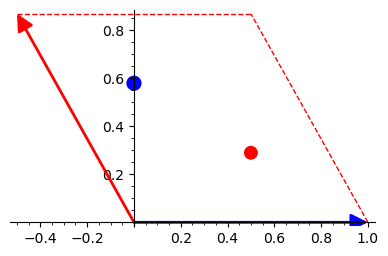

In [5]:
r_B=1/3*a_1+2/3*a_2; r_N=2/3*a_1+1/3*a_2
show(arrow((0,0),(a_1/a),color="blue")+
      arrow((0,0),(a_2/a),color="red")+
      line([(a_1/a),(a_1/a+a_2/a)],linestyle="--",color="red")+
      line([(a_2/a),(a_2/a+a_1/a)],linestyle="--",color="red")+
      point(r_B/a, size=120,color="blue")+
      point(r_N/a, size=100,color="red"), frame=False, figsize=4)

## Identificació dels veins segons la seua distància

Per construir la matriu dinàmica necessitem com a pas previ classificar el átoms del cristall segons la seua distància als àtoms de la cel.la unitat, ja que els clasificarem com primers, segons, tercers ... veïns segons aquesta distància i els asxignarem un tensor de constants de forces que dependrá de a quina familia de veïns pertanyen.

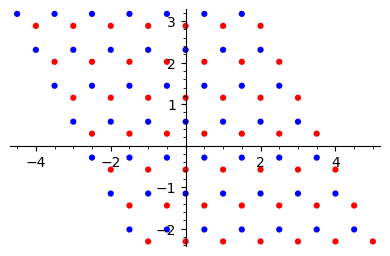

In [6]:
#Posicins d'equilibri dels àtoms
def RB(l_1,l_2):
    return (l_1*a_1+l_2*a_2+r_B)

def RN(l_1,l_2):
    return (l_1*a_1+l_2*a_2+r_N)

AtomosB=points([RB(l_1,l_2)/a for l_1 in range(-3, 4) for l_2 in range(-3,4)],size=20,color='blue')
AtomosN=points([RN(l_1,l_2)/a for l_1 in range(-3, 4) for l_2 in range(-3,4)],size=20,color='red')

show(AtomosB+AtomosN, figsize=4)

In [7]:
var('q_x, q_y'); assume(q_x, q_y, 'real'); q=vector([q_x,q_y])


## Parametros de la red, de la celdilla y del cristal
## Vector R_l (vector de traslación primitivo)
def R_l(l_1,l_2):
    return l_1*a_1+l_2*a_2

## Vector de posición de los átomos del cristal (en equilibrio)
def R_alpha_l(alpha,l_1,l_2):
    if alpha == 1:
        return l_1*a_1+l_2*a_2+r_B

    elif alpha == 2:
        return l_1*a_1+l_2*a_2+r_N

    else:
        print("Error, alpha solo puede ser 1 o 2 ")

## Vector unitario que une uno de los átomo alphaprima con el átomo considerado alpha, l_1,l_2
def R_hat(alphaprima,alpha,l_1,l_2):
    if (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprima,0,0)).norm()>0:
        return (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprima,0,0))/(R_alpha_l(alpha,l_1,l_2)\
                                                                 -R_alpha_l(alphaprima,0,0)).norm()
    else:
        return (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprima,0,0))

# Distancia entre el átomo alphaprime y su vecino alpha situado en la celdilla l_1,l_2
def distancia(alphaprime,alpha,l_1,l_2):
    return (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprime,0,0)).norm()/a    

def fase(l_1,l_2):
    return exp(I*q*R_l(l_1,l_2))

#Genero una lista con la distancia de cada átomo a los átomos de la celdilla unidad 
def valores_atomos(l_1, l_2):
    return [(k, m, i, j, R_hat(k, m, i, j), distancia(k,m,i,j)) for k in [1,2] for m in [1,2]  \
      for i in range(-l_1,l_1+1) for j in range(-l_2,l_2+1)]

## Construyo un DataFrame de pandas con la información necesaria para identificar a los primeros, segundos, ... vecinos, según su distancia a cada uno de los átomos de la celdilla unidad
columnas = [r"$\alpha\prime$",r"$\alpha$",r"$l_1$", r"$l_2$", r"$\hat R$",'Distancia']

def lista_atomos(l_1, l_2):
    return pd.DataFrame(valores_atomos(l_1,l_2),columns=columnas).sort_values(['Distancia',r"$\alpha\prime$"], ascending=[True,True])

## Mostramos el dataframe como una tabla
#table(lista_atomos(2,2).to_html(index=False))
table(lista_atomos(2,2).to_html(index=False))

,,,,,Distancia
1,1,0,0,"[0, 0]",0
2,2,0,0,"[0, 0]",0
1,2,-1,0,"[-3/2*sqrt(1/3), -1/2*sqrt(3)*sqrt(1/3)]",sqrt(1/3)
1,2,0,0,"[3/2*sqrt(1/3), -1/2*sqrt(3)*sqrt(1/3)]",sqrt(1/3)
1,2,0,1,"[0, sqrt(3)*sqrt(1/3)]",sqrt(1/3)
2,1,0,-1,"[0, -sqrt(3)*sqrt(1/3)]",sqrt(1/3)
2,1,0,0,"[-3/2*sqrt(1/3), 1/2*sqrt(3)*sqrt(1/3)]",sqrt(1/3)
2,1,1,0,"[3/2*sqrt(1/3), 1/2*sqrt(3)*sqrt(1/3)]",sqrt(1/3)
1,1,-1,-1,"[-1/2, -1/2*sqrt(3)]",1
1,1,-1,0,"[-1, 0]",1


## Tensor de constants de forca i matriu dinàmica

Una vegada descrit el nostre sistema físic anem a obtindre la matriu dinàmica d'aquest, ja que com hem vist els seus valors propis, $\omega^2$, ens donen la freqüència de propagació de cadascun dels modes.

Obtesses les posicions dels àtoms y classificats estos com primers, segons, etc. veïns, segons la distància al respectiu àtom de la ce\l.la $\vec 0$, procedim a calcular la contribució a la matriu dinàmica de cadascun dels àtoms, per la qual cosa necessitem conèixer el tensor de constants de força que correspon a la interacció de cada àtom amb el seu n-èssim veí.

La forma general del tensor de forces d'un $n$-èssim veí és de la forma (cite wirtz04 phonon disper graph revis): 


\begin{equation}
C_n=\begin{pmatrix}
\phi_n^1&\xi_n &0\\
-\xi_n & \phi_n^{ti} & 0 \\
0 & 0 & \phi_n^{to}
\end{pmatrix}
\label{eq:tensordeforces}
\end{equation}

on el sistema de coordenadas se eligeix de manera que $x$ és la coordenada longitudinal (en la línia que conecta els dos àtomos), $y$ la coordenada transversal en el planol i $z$ la coordenada perperndicular al planol. L'estructura diagonal a blocs de la matriu reflexa el fet que las vibracions interplanars y les de fora de plà (en la direcció $z$) estan completament desacoblades.



Anem a supossar (per simplificar) que un desplaçament longitudinal (radial, que estarà contés en el planol del cristall) o transversal (tangencial, siga en el planol o perpendicular al planol) sols genera una força radial o transversal, es a dir, $\xi_n=0$ tal y com es realitza en la referència cite Balkanski 2000. Esta aproximació es coneix com l'aproximació /4NNFC/, i es necessita considerar fins els cuarts veïns per donar compte dels resultats experimentals.

Por tant, com primera aproximació anem a considerar que el tensor de constants de for\c{c}a  d'un àtom classificat com $n$-èssim, situat en la direcció $\hat x$ respecte del átom de la ce\l.la $\vec 0$, té la forma diagonal:

\begin{equation}
C_n=\begin{pmatrix}
\phi_n^r& 0 &0\\
0 & \phi_n^{ti} & 0 \\
0 & 0 & \phi_n^{to}
\end{pmatrix}
\end{equation}

i per tant el tensor de constants de for\c{c}a de cadascun dels $n$-èssims veïns reals l'obtenim rotant esta matriu:
\vspace{4cm}


Un punt important és que quan considerem la interacció entre àtoms del mateix tipus (en el cas del BN és fácil discriminarlos, ja que són àtoms de distints elements els que conformen la base), tenim que considerar la contribució a la matriu dinámica de l'àtom que estamos considerant de la ce\.l.la $\vec 0$. Esta contribució podem derivar-la de la condició d'estabilitat, \cite{falkovsky08_symmet_const_phonon_disper_graph}
\cite{wirtz04_phonon_disper_graph_revis}

Si es desplaca el cristall com un tot no canvia l'energía potencial, cosa que implica s'ha de complir:
 
......


Podem tindre en compte altres simetries del cristall per determinar certes propietats del tensor de forces o de la seua transformada de Fourier, la matriu dinàmica (certes relacions entre les components ...) però per ara sols tindrem en compte que la matriu dinàmica es una matri hermítica, i per tant els seus valors propis, $\omega^2$ tenen que ser reals.

In [8]:
#Angle que forma l'àtom considerat respecte a l'eix x

def angulo(alphaprima,alpha,l_1,l_2):
    if R_hat(alphaprima,alpha,l_1,l_2)[1] <0:
        return -acos(R_hat(alphaprima,alpha,l_1,l_2)*vector([1,0]))
    
    else:
        return acos(R_hat(alphaprima,alpha,l_1,l_2)*vector([1,0]))

#Matriz unitaria de rotación para cambio de ejes coordenados (entorno al eje z)

def U(theta):
    return matrix([[cos(theta),sin(theta),0], [-sin(theta), cos(theta),0],[0,0,1]])

#Matriz de fuerza para los primeros vecinos

var('M_B,M_N', domain='positive')
var('omega')

phi1rBN=var('phi1rBN',latex_name='\\phi_{1,r}^{BN}')
phi1tiBN=var('phi1tiBN',latex_name='\\phi_{1,ti}^{BN}')
phi1toBN=var('phi1toBN',latex_name='\\phi_{1,to}^{BN}',domain='real')

phi1rNB=phi1rBN; phi1tiNB=phi1tiBN; phi1toNB=phi1toBN


Phi_10__BN=1/sqrt(M_B*M_N)*Matrix([[phi1rBN,0,0],[0,phi1tiBN,0],[0,0,phi1toBN]])
Phi_10__NB=1/sqrt(M_N*M_B)*Matrix([[phi1rNB,0,0],[0,phi1tiNB,0],[0,0,phi1toNB]])


def Phi_1l__BN(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_10__BN*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def Phi_1l__NB(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_10__NB*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def D_1l_BN(alphaprima,alpha,l_1,l_2):
    return Phi_1l__BN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_1l_NB(alphaprima,alpha,l_1,l_2):
    return Phi_1l__NB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

# Matriz de fuerza para los segundos vecinos

phi2rBB=var('phi2rBB',latex_name='\\phi_{2,r}^{BB}')
phi2tiBB=var('phi2tiBB',latex_name='\\phi_{2,ti}^{BB}')
phi2toBB=var('phi2toBB',latex_name='\\phi_{2,to}^{BB}',domain='real')

phi2rNN=var('phi2rNN',latex_name='\\phi_{2,r}^{NN}')
phi2tiNN=var('phi2tiNN',latex_name='\\phi_{2,ti}^{NN}')
phi2toNN=var('phi2toNN',latex_name='\\phi_{2,to}^{NN}',domain='real')

Phi_20__BB=1/M_B*Matrix([[phi2rBB,0,0],[0,phi2tiBB,0],[0,0,phi2toBB]])
Phi_20__NN=1/M_N*Matrix([[phi2rNN,0,0],[0,phi2tiNN,0],[0,0,phi2toNN]])

#A tener en cuenta: cuando consideramos el mismo tipo de átomos 
# (de la misma subred, no porque sean el mismmo elemento)

def Phi_2l__BB(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_20__BB*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def Phi_2l__NN(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_20__NN*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def D_2l_BB(alphaprima,alpha,l_1,l_2):
    return Phi_2l__BB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_2l_NN(alphaprima,alpha,l_1,l_2):
    return Phi_2l__NN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)


#Matriz de fuerza para los terceros vecinos

phi3rBN=var('phi3rBN',latex_name='\\phi_{3,r}^{BN}')
phi3tiBN=var('phi3tiBN',latex_name='\\phi_{3,ti}^{BN}')
phi3toBN=var('phi3toBN',latex_name='\\phi_{3,to}^{BN}',domain='real')
phi3rNB,phi3tiNB,phi3toNB=phi3rBN,phi3tiBN,phi3toBN
Phi_30__BN=1/sqrt(M_B*M_N)*Matrix([[phi3rBN,0,0],[0,phi3tiBN,0],[0,0,phi3toBN]])
Phi_30__NB=1/sqrt(M_N*M_B)*Matrix([[phi3rNB,0,0],[0,phi3tiNB,0],[0,0,phi3toNB]])
                   
def Phi_3l__BN(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_30__BN*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def Phi_3l__NB(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_30__NB*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def D_3l_BN(alphaprima,alpha,l_1,l_2):
    return Phi_3l__BN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_3l_NB(alphaprima,alpha,l_1,l_2):
    return Phi_3l__NB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

#Matriz de fuerza para los cuartos vecinos
phi4rBN=var('phi4rBN',latex_name='\\phi_{4,r}^{BN}')
phi4tiBN=var('phi4tiBN',latex_name='\\phi_{4,ti}^{BN}')
phi4toBN=var('phi4toBN',latex_name='\\phi_{4,to}^{BN}',domain='real')
phi4rNB,phi4tiNB,phi4toNB=phi4rBN,phi4tiBN,phi4toBN

Phi_40__BN=1/sqrt(M_B*M_N)*Matrix([[phi4rBN,0,0],[0,phi4tiBN,0],[0,0,phi4toBN]])
Phi_40__NB=1/sqrt(M_N*M_B)*Matrix([[phi4rNB,0,0],[0,phi4tiNB,0],[0,0,phi4toNB]])

def Phi_4l__BN(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_40__BN*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def Phi_4l__NB(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_40__NB*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def D_4l_BN(alphaprima,alpha,l_1,l_2):
    return Phi_4l__BN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_4l_NB(alphaprima,alpha,l_1,l_2):
    return Phi_4l__NB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

# Finalmente construimos la matriz dinámica "a capas"
# Con la tabla de la celda de codigo anterior comprobamos que para considerar 
# hasta los cuartos vecinos es suficiente con l_1,l_2=2
                   
D1BN, D1NB, D2BB, D2NN, D3BN, D3NB, D4BN, D4NB = (matrix(3) for i in range(8))
D01BN, D01NB, D02BB, D02NN, D03BN, D03NB, D04BN, D04NB= (matrix(3) for i in range(8))
for k in [1,2]:
    for m in [1,2]:
         for i in range(-2,3):
            for j in range(-2,4):
                if (k==1) & bool( distancia(k,m,i,j) == sqrt(3)/3 ):
                    D1BN += D_1l_BN(k,m,i,j)
                    D01BN += Phi_1l__BN(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == sqrt(3)/3 ):
                    D1NB += D_1l_NB(k,m,i,j)
                    D01NB += Phi_1l__NB(k,m,i,j)
                 
                elif (k==1) & bool( distancia(k,m,i,j) == 1):
                    D2BB += D_2l_BB(k,m,i,j)
                    D02BB += Phi_2l__BB(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == 1):
                    D2NN += D_2l_NN(k,m,i,j)
                    D02NN += Phi_2l__NN(k,m,i,j)

                elif (k==1) & bool( distancia(k,m,i,j) == 2*sqrt(3)/3 ):
                    D3BN += D_3l_BN(k,m,i,j)
                    D03BN += Phi_3l__BN(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == 2*sqrt(3)/3 ):
                    D3NB += D_3l_NB(k,m,i,j)
                    D03NB += Phi_3l__NB(k,m,i,j)
                    
                elif (k==1) & bool( distancia(k,m,i,j) == sqrt(7/3)):
                    D4BN += D_4l_BN(k,m,i,j)
                    D04BN += Phi_4l__NB(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == sqrt(7/3)):
                    D4NB += D_4l_NB(k,m,i,j)
                    D04NB += Phi_4l__NB(k,m,i,j)

# Tenemos en cuenta la contribución a la matriz dinámica de los átomos situados en 
# la celdilla 0
D2BB=D2BB-D01BN-D02BB-D03BN
D2NN=D2NN-D01NB-D02NN-D03NB                    

Tenim per tant que la matriu dinàmica serà una matriu $6x6$ hermítica. Però donat que les components en $z$ d'esta matriu es troben desacoblades podem tractar aquestes vibracions de manera independent.


## Vibracions fora de pla

Donat que les vibracions fora de pla són, per com hem construït la matriu dinàmica, independients de les interplanars, podem estudiar primer les vibracions fora de pla.

In [9]:
D1BN_zz=D1BN[2,2]
D1NB_zz=D1NB[2,2]

D2BB_zz=D2BB[2,2]
D2NN_zz=D2NN[2,2]

D3BN_zz=D3BN[2,2]
D3NB_zz=D3NB[2,2]
D4BN_zz=D4BN[2,2]
D4NB_zz=D4NB[2,2]

#D_zz=Matrix([[D2BB_zz,D1BN_zz+D3BN_zz+D4BN_zz], [D1NB_zz+D3NB_zz+D4BN_zz,D2NN_zz]])
#Si considerem fins als 4ts veïns la constant de força phi4toBN té que ser nul.la perquè 
#un dels valors propis en Gamma s'anul.le: no fa falta considerar en este cas

D_zz=Matrix([[D2BB_zz,D1BN_zz+D3BN_zz], [D1NB_zz+D3NB_zz,D2NN_zz]])

#valors_propis_D_zz=D_zz.eigenvalues()
#D_zz[0,0].simplify_full()

### Punt $\Gamma$

Per al punt $(k_x=0, k_y=0)$

In [10]:
from periodictable import C, B, N, constants
u=constants.atomic_mass_constant*10**3 #para que este en CGS (y las const. de fuerza en dyn)

omega_Gamma_ZO=830 #cm-1
omega_Gamma_ZA=0
D_Gamma_zz=D_zz.subs(q_x=0,q_y=0) #,(M_B,B.mass*u),(M_N,N.mass*u)])
D_Gamma_zz

[-3*phi1toBN/sqrt(M_B*M_N) - 3*phi3toBN/sqrt(M_B*M_N)  3*phi1toBN/sqrt(M_B*M_N) + 3*phi3toBN/sqrt(M_B*M_N)]
[ 3*phi1toBN/sqrt(M_B*M_N) + 3*phi3toBN/sqrt(M_B*M_N) -3*phi1toBN/sqrt(M_B*M_N) - 3*phi3toBN/sqrt(M_B*M_N)]

In [11]:
D_Gamma_zz.eigenvalues()

[-6*(phi1toBN + phi3toBN)/sqrt(M_B*M_N), 0]

In [12]:
Eq1=solve(D_Gamma_zz.eigenvalues()[0]==omega_Gamma_ZO**2, phi3toBN)
#Eq1

### Punt $M$
Al punt $\left(q_x=\pi/a,q_y=\pi/(\sqrt 3 a\right)$

In [13]:
omega_M_ZO=635 #cm-1
omega_M_ZA=314

D_M_zz=D_zz.subs(q_x=pi/a,q_y=pi/(sqrt(3)*a))
#D_M_zz.eigenvalues()

In [14]:
# Podem simplificar un poc l'expressió obtessa per als valores propios al punto $M$ (simplement reescribint l'argumento de l'arrel quadrada)
omegaM1cuadrado=-4*phi2toBB/M_B-4*phi2toNN/M_N-3/sqrt(M_B*M_N)*(phi1toBN+phi3toBN)-sqrt(M_B*M_N*(phi1toBN-3*phi3toBN)^2+(4*(M_N*phi2toBB-M_B*phi2toNN))^2)/(M_B*M_N)
if bool(D_M_zz.eigenvalues()[0]==omegaM1cuadrado):
    Eq5=(omegaM1cuadrado==omega_M_ZO**2)

omegaM2cuadrado=-4*phi2toBB/M_B-4*phi2toNN/M_N-3/sqrt(M_B*M_N)*(phi1toBN+phi3toBN)+sqrt(M_B*M_N*(phi1toBN-3*phi3toBN)^2+(4*(M_N*phi2toBB-M_B*phi2toNN))^2)/(M_B*M_N)
if bool(D_M_zz.eigenvalues()[1]==omegaM2cuadrado):
    Eq6=(omegaM2cuadrado==omega_M_ZA**2)
    
show(omegaM1cuadrado)
show(omegaM2cuadrado)

-3*(phi1toBN + phi3toBN)/sqrt(M_B*M_N) - 4*phi2toBB/M_B - 4*phi2toNN/M_N - sqrt(M_B*M_N*(phi1toBN - 3*phi3toBN)^2 + 16*(M_N*phi2toBB - M_B*phi2toNN)^2)/(M_B*M_N)

-3*(phi1toBN + phi3toBN)/sqrt(M_B*M_N) - 4*phi2toBB/M_B - 4*phi2toNN/M_N + sqrt(M_B*M_N*(phi1toBN - 3*phi3toBN)^2 + 16*(M_N*phi2toBB - M_B*phi2toNN)^2)/(M_B*M_N)

In [15]:
# Si considerem que els àtoms són iguals
#D_M_zz.subs(M_B=M_N, phi2toBB=phi2toNN).eigenvalues()

### Punt $K$ 
Per al punt ($k_x=4\pi/(3 a)$, $k_y=0$)

In [16]:
omega_K_ZO=605 #cm-1
omega_K_ZA=322
D_K_zz=D_zz.subs(q_x=4*pi/(3*a),q_y=0)
D_K_zz.eigenvalues()
#solve(det(D_K_zz-omega**2)==0, omega**2)

[-3*(M_N*phi1toBN + M_N*phi3toBN + 3*sqrt(M_B*M_N)*phi2toNN)/(sqrt(M_B*M_N)*M_N),
 -3*(M_B*phi1toBN + M_B*phi3toBN + 3*sqrt(M_B*M_N)*phi2toBB)/(sqrt(M_B*M_N)*M_B)]

Notem que en el cas del BN, a diferència del cas del grafè, obtenim 2 freqüenciès distintes al punt K ja que la base està constituïda per dos àtoms d'elements distints.

In [17]:
sol=[]
Eq2=D_K_zz.eigenvalues()[0]==omega_K_ZO**2
Eq3=D_K_zz.eigenvalues()[1]==omega_K_ZA**2
sol.append(solve(Eq2.subs(Eq1),phi2toNN)[0])
sol.append(solve(Eq3.subs(Eq1),phi2toBB)[0])
sol

[phi2toNN == -21575/9*M_N, phi2toBB == 240766/9*M_B]

És directe comprobar que en el cas que els àtoms foren idèntics obtindríem les mateixes expressions que en Falkowsky

In [18]:
#sol.append(solve(((Eq5-Eq6)**2).subs(sol[0], sol[1], solEq1[0],M_N=N.mass, M_B=B.mass), phi1toBN)[1])
sol1=(phi1toBN==n(solve(((Eq6-Eq5)**2).subs(Eq1), phi1toBN)[0].subs(sol[0], sol[1]).subs(M_B=B.mass, \
    M_N=N.mass).rhs()))
sol2=sol[0].subs(M_N=N.mass)
sol3=sol[1].subs(M_B=B.mass)
sol4=Eq1[0].subs(M_B=B.mass, M_N=N.mass).subs(sol1)
show(sol1)
show(sol2)
show(sol3)
show(sol4)

phi1toBN == -1.36116402436406e6

phi2toNN == -33577.1725

phi2toBB == 289213.46955555555

phi3toBN == -51717.6151722642

In [19]:
dades=loadtxt("../Dades/freq.dat")
#data = pd.read_csv('../../Dades/freq.dat', header = None)

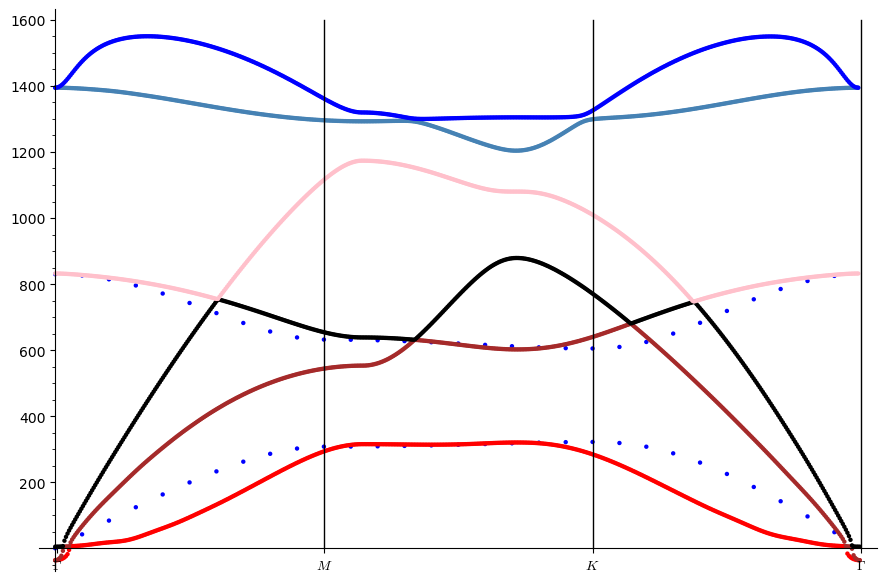

In [20]:
show(\
list_plot(
    [real_part(n(sqrt(D_zz.subs(sol1, sol2, sol3, sol4, M_B=B.mass, \
        M_N=N.mass, a=1, q_x=n(x*pi), q_y=n(x*pi/sqrt(3))).simplify_full().eigenvalues()[1]))) \
        for x in srange(0,1,0.1)] +\
         [real_part(n(sqrt(D_zz.subs(sol1, sol2, sol3, sol4, M_B=B.mass, \
M_N=N.mass, a=1, q_x=n(pi*(1+x/3)), q_y=n(pi/sqrt(3)*(1-x))).simplify_full().eigenvalues()[1]))) \
        for x in srange(0,1,0.1)]+\
         [real_part(n(sqrt(D_zz.subs(sol1, sol2, sol3, sol4, M_B=B.mass, \
M_N=N.mass, a=1, q_x=n(4*pi/3*(1-x)), q_y=0).simplify_full().eigenvalues()[1]))) \
        for x in srange(0,1,0.1)]) + \
list_plot(
    [real_part(n(sqrt(D_zz.subs(sol1, sol2, sol3, sol4, M_B=B.mass, \
        M_N=N.mass, a=1, q_x=n(x*pi), q_y=n(x*pi/sqrt(3))).simplify_full().eigenvalues()[0]))) \
        for x in srange(0,1,0.1)]+
          [real_part(n(sqrt(D_zz.subs(sol1, sol2, sol3, sol4, M_B=B.mass, \
M_N=N.mass, a=1,q_x=n(pi*(1+x/3)), q_y=n(pi/sqrt(3)*(1-x))).simplify_full().eigenvalues()[0]))) \
        for x in srange(0,1,0.1)]+\
         [real_part(n(sqrt(D_zz.subs(sol1, sol2, sol3, sol4, M_B=B.mass, \
M_N=N.mass, a=1, q_x=n(4*pi/3*(1-x)), q_y=0).simplify_full().eigenvalues()[0]))) \
        for x in srange(0,1,0.1)]) \
     +line([(10,0),(10,1600)], color="black")+line([(20,0),(20,1600)], color="black")\
     +line([(30,0),(30,1600)], color="black", ticks=[[0.05,10,20,30], None], \
        tick_formatter = [[r'$\Gamma$', '$M$', '$K$', r'$\Gamma$'], None])+\
points(zip(dades[:524,0]/524*30, dades[:524,1]), color="red") +\
points(zip(dades[524:1048,0]/524*30, dades[524:1048,1]), color="brown") +\
points(zip(dades[1048:1572,0]/524*30, dades[1048:1572,1]), color="black") +\
points(zip(dades[1572:2096,0]/525*30, dades[1572:2096,1]), color="pink") +\
points(zip(dades[2096:2620,0]/525*30, dades[2096:2620,1]), color="steelblue") +\
points(zip(dades[2620:3144,0]/525*30, dades[2620:3144,1]), color="blue")     
     ,figsize=9) 

| Serie | Color  | Punt  | $\omega$ |    Rama |
|-------|--------|-------|----------|---------|
|     1 | Roig   | $\Gamma$ |       0    |  1 (ZA) |
|     1 | Roig   | M     |        314    | 1 (ZA) |
|     1 | Roig   | K     |       320     |1 (ZA) |
|     2 | Marro  | $\Gamma$ |       0    |2 (TA) |
|     2 | Marro  | M     |           553 |2 (TA) |
|     2 | Marro  | K     |           602 | 4 (ZO) |
|     3 | Negre  | $\Gamma$ |         4  | 3 (LA) |
|     3 | Negre  | M     |           638 | 4 (ZO) |
|     3 | Negre  | K     |           878 |     2(TA) |
|     4 | Rosa   | $\Gamma$ |        831 |  4 (ZO) |
|     4 | Rosa   | M     |          1173 |       3 (LA) |
|     4 | Rosa   | K     |          1080 |       3 (LA) |
|     5 | B.clar | $\Gamma$ |       1394 |       5 (TO) |
|     5 | B.clar | M     |          1292 |       5 (TO)|
|     5 | B.clar | K     |          1204 |       5 (TO)|
|     6 | Blau   | $\Gamma$ |       1394 |       6 (LO)|
|     6 | Blau   | M     |          1320 |       6 (LO)|
|     6 | Blau   | K     |          1304 |       6 (LO)|

## Vibracions dins del pla del cristall
En este cas tractem amb una matriu $4\times 4$, i per tant tenim 4 valors propis ($\omega^2$)

In [21]:
D1BN_xy=D1BN.matrix_from_rows_and_columns([0,1],[0,1])
D1NB_xy=D1NB.matrix_from_rows_and_columns([0,1],[0,1])

D2BB_xy=D2BB.matrix_from_rows_and_columns([0,1],[0,1])
D2NN_xy=D2NN.matrix_from_rows_and_columns([0,1],[0,1])
               
D3BN_xy=D3BN.matrix_from_rows_and_columns([0,1],[0,1])
D3NB_xy=D3NB.matrix_from_rows_and_columns([0,1],[0,1])
D4BN_xy=D4BN.matrix_from_rows_and_columns([0,1],[0,1])
D4NB_xy=D4NB.matrix_from_rows_and_columns([0,1],[0,1])

D_xy=block_matrix([[D2BB_xy, D1BN_xy+D3BN_xy+D4BN_xy],[D1NB_xy+D3NB_xy+D4NB_xy, D2NN_xy]])

### Al punt $\Gamma$

Al punt $\Gamma$ obtinc 2 valors propis, de multiplicitat $2$ cadascun:

In [22]:
D_Gamma_xy=D_xy.subs(q_x=0,q_y=0)

In [23]:
for i in range(4):
    show(D_Gamma_xy.eigenvalues()[i])
    

-3*sqrt(M_B*M_N)*(phi1rBN + phi1tiBN + phi3rBN + phi3tiBN + phi4rBN + phi4tiBN)/(M_B*M_N)

-3*sqrt(M_B*M_N)*(phi1rBN + phi1tiBN + phi3rBN + phi3tiBN + phi4rBN + phi4tiBN)/(M_B*M_N)

3*sqrt(M_B*M_N)*(phi4rBN + phi4tiBN)/(M_B*M_N)

3*sqrt(M_B*M_N)*(phi4rBN + phi4tiBN)/(M_B*M_N)

Obtenim dos valors propis:
per tal que un d'ells siga $0$ té que complir-se que: $\phi_{4,ti}^{BN}=-\phi_{4,r}^{BN}$

In [24]:
D_Gamma_xy=D_xy.subs(q_x=0,q_y=0,phi4tiBN=-phi4rBN)
for i in range(4):
    show(D_Gamma_xy.eigenvalues()[i])
       

-3*(phi1rBN + phi1tiBN + phi3rBN + phi3tiBN)/sqrt(M_B*M_N)

-3*(phi1rBN + phi1tiBN + phi3rBN + phi3tiBN)/sqrt(M_B*M_N)

0

0

In [25]:
omega_Gamma_5i6=1394
Eq_Gamma_5i6=(D_Gamma_xy.eigenvalues()[0]==omega_Gamma_5i6**2)
#Eq_Gamma_5
Eq7=solve(Eq_Gamma_5i6,phi3rBN)[0].subs(M_B=B.mass,M_N=N.mass)
Eq7

phi3rBN == -phi1rBN - phi1tiBN - phi3tiBN - 7970859.241358685

```{note}
Per als punts $K$ i $M$, sagemath (mitjançant [maxima](https://maxima.sourceforge.io/)) no obté una expressió analítica però el que fem és calcular els valors propis supossant que els 2 àtoms de la base tenen la mateixa massa (no fa falta supossar que les constants de força entre àtoms del mateix tipus -segons veïns- són iguals). 

Amb aquesta simplificació podem calcular fàcilment els valors propis de la matriu original
```

### Al punt $M$
En ($q_x=\pi/a,q_y=\pi/(\sqrt{3} a$)

In [26]:
D_M_xy=D_xy.subs(q_x=pi/a,q_y=pi/(sqrt(3)*a),phi4tiBN=-phi4rBN)
D_M_xy_simplificada=D_M_xy.subs(M_N=M_B)
Valors_propis_M=D_M_xy_simplificada.eigenvalues()

Valors_propis_de_M=[M_B*Valors_propis_M[i].expand().subs(
    phi1rBN=phi1rBN/sqrt(M_N*M_B), phi1tiBN=phi1tiBN/sqrt(M_N*M_B), 
    phi2rBB=phi2rBB/M_B, phi2tiBB=phi2tiBB/M_B,
    phi2rNN=phi2rNN/M_N, phi2tiNN=phi2tiNN/M_N,
    phi3rBN=phi3rBN/sqrt(M_N*M_B), phi3tiBN=phi3tiBN/sqrt(M_N*M_B),
    phi4rBN=phi4rBN/sqrt(M_N*M_B), phi4tiBN=phi4tiBN/sqrt(M_N*M_B)) for i in range(4)]

#Comprobem que sí són els valors propis:
[det(D_M_xy-Valors_propis_de_M[i]) for i in range(4)]

[0, 0, 0, 0]

In [27]:
omega_M_2=553
omega_M_3=1173
omega_M_5=1292
omega_M_6=1320

In [28]:
(Valors_propis_de_M[0]+Valors_propis_de_M[1]).expand()

-3*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 2*phi2rBB/M_B - 2*phi2rNN/M_N - 6*phi2tiBB/M_B - 6*phi2tiNN/M_N - 3*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

In [29]:
(Valors_propis_de_M[2]+Valors_propis_de_M[3]).expand()

-3*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 6*phi2rBB/M_B - 6*phi2rNN/M_N - 2*phi2tiBB/M_B - 2*phi2tiNN/M_N - 3*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

In [30]:
(Valors_propis_de_M[0]+Valors_propis_de_M[1]).expand()-(
    Valors_propis_de_M[2]+Valors_propis_de_M[3]).expand()

4*phi2rBB/M_B + 4*phi2rNN/M_N - 4*phi2tiBB/M_B - 4*phi2tiNN/M_N

In [31]:
(Valors_propis_de_M[0]+Valors_propis_de_M[1]).expand() - 3*(
    Valors_propis_de_M[2]+Valors_propis_de_M[3]).expand()

6*phi1rBN/(sqrt(M_B)*sqrt(M_N)) + 6*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) + 16*phi2rBB/M_B + 16*phi2rNN/M_N + 6*phi3rBN/(sqrt(M_B)*sqrt(M_N)) + 6*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

Al punt $M$ obtenim  4 valors propis diferents. Cosa que sembla raonable observant la gràfica de les dades proporcionades.


### Al punt $K$ 
En $\left(k_x=\frac{4\pi}{3a}, k_y=0\right)$

In [32]:
D_K_xy=D_xy.subs(q_x=4*pi/(3*a),q_y=0, phi4tiBN=-phi4rBN)
D_K_xy_simplificada=D_K_xy.subs(M_N=M_B)
Valors_propis_K=D_K_xy_simplificada.eigenvalues()

Valors_propis_de_K=[M_B*Valors_propis_K[i].expand().subs(
    phi1rBN=phi1rBN/sqrt(M_N*M_B), phi1tiBN=phi1tiBN/sqrt(M_N*M_B), 
    phi2rBB=phi2rBB/M_B, phi2tiBB=phi2tiBB/M_B,
    phi2rNN=phi2rNN/M_N, phi2tiNN=phi2tiNN/M_N,
    phi3rBN=phi3rBN/sqrt(M_N*M_B), phi3tiBN=phi3tiBN/sqrt(M_N*M_B),
    phi4rBN=phi4rBN/sqrt(M_N*M_B), phi4tiBN=phi4tiBN/sqrt(M_N*M_B)) for i in range(4)]

#Comprobem que sí són els valors propis:
[det(D_K_xy-Valors_propis_de_K[i]) for i in range(4)]

[0, 0, 0, 0]

Dos dels valors propis contenen una arrel amb prou termes, que no val la pena mostrar, mostre sols els més "sencills":

In [33]:
for i in range(2):
    show(Valors_propis_de_K[i].expand())

-3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 9/2*phi2rNN/M_N - 9/2*phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

-3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 9/2*phi2rBB/M_B - 9/2*phi2tiBB/M_B - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

In [34]:
omega_K_2=878
omega_K_3=1089
omega_K_5=1204
omega_K_6=1304
#Eq_K_5i6=(D_K_xy_0.eigenvalues()[2]==omega_K_2**2)
#Eq_K_3=(D_K_xy_0.eigenvalues()[1]==omega_K_3**2)
#Eq_K_2=(D_K_xy_0.eigenvalues()[0]==omega_K_2**2)
#Eq8=solve((solve(Eq_K_5i6,phi3rBN)[0].subs(M_B=B.mass,M_N=N.mass).rhs()-solve(Eq_Gamma_5i6,
#    phi3rBN)[0].subs(M_B=B.mass,M_N=N.mass).rhs()==0),phi2rBB)[0].subs(M_B=B.mass,M_N=N.mass)
#show(Eq8)
#solve((Eq_K_3+Eq_K_2).expand().subs(Eq7,M_B=B.mass), phi2rBB)

In [35]:
(Valors_propis_de_K[0].expand()+Valors_propis_de_K[1]).expand()

-3*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 9/2*phi2rBB/M_B - 9/2*phi2rNN/M_N - 9/2*phi2tiBB/M_B - 9/2*phi2tiNN/M_N - 3*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

In [36]:
(Valors_propis_de_K[2].expand()+Valors_propis_de_K[3]).expand()

-3*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 9/2*phi2rBB/M_B - 9/2*phi2rNN/M_N - 9/2*phi2tiBB/M_B - 9/2*phi2tiNN/M_N - 3*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

In [37]:
(Valors_propis_de_K[0]-Valors_propis_de_K[1]).expand()

9/2*phi2rBB/M_B - 9/2*phi2rNN/M_N + 9/2*phi2tiBB/M_B - 9/2*phi2tiNN/M_N

In [38]:
(Valors_propis_de_M[0]+Valors_propis_de_M[1]).expand()- (
    Valors_propis_de_M[2]+Valors_propis_de_M[3]).expand() + 8/9*((Valors_propis_de_K[0]-Valors_propis_de_K[1]).expand())

8*phi2rBB/M_B - 8*phi2tiNN/M_N